In [1]:
'''
MIT License

Copyright (c) 2018 Brian McKean

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

'\nMIT License\n\nCopyright (c) 2018 Brian McKean\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM

In [2]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')
import seaborn as sns
from math import log10, floor
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.cluster import KMeans, MiniBatchKMeans
from IPython.display import Image
from IPython.core.display import HTML

import matplotlib.pyplot as plt
import urllib.request

In [3]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")
#
# Get collections from mongodb
#

db = client.test

Setup db access


In [4]:
# Find all qual_id's
qual_ids =  db.anon_student_task_responses.distinct('qual_id')




In [5]:
# print (len(qual_ids), qual_ids)

In [6]:
# Get count of qual_id with failures
qual_id_counts =  db.anon_student_task_responses.aggregate(
  [{           
    '$group': {
      '_id': {
        'qual_id': '$qual_id'
      },
      'count': {
        '$sum': 1
      }
    }
    
  }
   ]
)

In [7]:
 qual_id_counts = list(qual_id_counts)

In [8]:
qual_count_df = pd.DataFrame(qual_id_counts)

In [9]:
# print (qual_id_counts)

In [10]:
# print (qual_count_df)

In [11]:
qual_count_df = qual_count_df.sort_values(by='count', ascending=False)

In [12]:
qual_count_df.reset_index(drop=True,inplace=True)
# print (qual_count_df)

In [13]:
qual_id_fail_counts =  db.anon_student_task_responses.aggregate(
  [{           
    '$group': {
      '_id': {
        'qual_id': '$qual_id',
        'correct': 'False'             
      },
      'count': {
        '$sum': 1
      }
    }
    
  }
   ]
)

In [14]:
qual_id_fail_counts = list(qual_id_fail_counts)

In [15]:
qual_fail_count_df = pd.DataFrame(qual_id_fail_counts)

In [16]:
qual_fail_count_df.sort_values(by='count', inplace=True, ascending=False)

In [17]:
# qual_fail_count_df 

In [18]:
## Functions for turning dictionary into document

def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
    
        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans

In [19]:
def make_doc_data_set(prob_set):
    df3 = pd.DataFrame(list(prob_set))
    df3['response_doc'] = df3['response'].map(make_string)
    df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))
    df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 
    df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))
    return df3
    


In [20]:


def make_k_means(data_samples, n_features=200, n_topic=30, n_top_words=10, clusters=10):
    n_samples = len(data_samples)
    print("Extracting tf-idf features ...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    
    # Number of clusters
    true_k = clusters
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                             init_size=1000, batch_size=1000, random_state=62)
    print("Clustering with %s" % km)
    t0 = time()
    km_transform = km.fit_transform(tfidf)
    print("done in %0.3fs" % (time() - t0))
    return km, km_transform


In [21]:
top_ten_qual_id = qual_count_df[:10]

In [22]:
this_qid = top_ten_qual_id.iloc[0]['_id']['qual_id']

In [23]:
df_top_ten = []

Analysis 0 for qual_id xSDXuo9OEH.bonus.OG_XxtbnEa with 22752 samples
Session 0 txt  Model a fraction that is equal to  1/4  of the black circle
by covering it with red  1/12  pieces.
Answer: [object Object]
Extracting tf-idf features ...
done in 1.771s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.294s
qual_id xSDXuo9OEH.bonus.OG_XxtbnEa has these clusters
1    3867
2    3646
3    1030
5     997
9     991
7     939
0     897
4     833
6     372
8     368
Name: cluster, dtype: int64
Distances (13940, 10) [[ 1.0785264   0.65347641  0.31048295 ...,  0.60054907  0.99770037
   0.73358218]
 [ 1.0659002   0.6935771   0.40102391 ...,  0.62903396  1.00514641
   0.72554528]
 [ 1.16267338  0.82031401  1.01248021 ...,  1.02725468  1.05599033
   1.1037258 ]
 ..., 
 [ 0.77774549  0.902

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                            _id behavioral_traits  bonus  correct  diff  \
13939  59d27105d0cd262c1b00ca9b               NaN   True    False   0.5   
10444  5a0114619100de1a398d2d86                []   True    False   0.5   
10452  5a0114669100de1a398d4249                []   True    False   0.5   
4673   5a00fe029100de1a3933da8b                []   True    False   0.5   
10453  5a0114669100de1a398d424a                []   True    False   0.5   
4663   5a00fe019100de1a3933d783                []   True    False   0.5   
4662   5a00fdff9100de1a3933cfee                []   True    False   0.5   
4661   5a00fdff9100de1a3933cfa1                []   True    False   0.5   
4660   5a00fdfd9100de1a3933c8fb                []   True    False   0.5   
10457  5a0114709100de1a398d6a22                []   True    False   0.5   

               id  incomplete          lesson  \
13939  OG_XxtbnEa       False  model_symbol_5   
10444  OG_XxtbnEa       False  model_symbol_5   
10452  OG_XxtbnEa       Fal

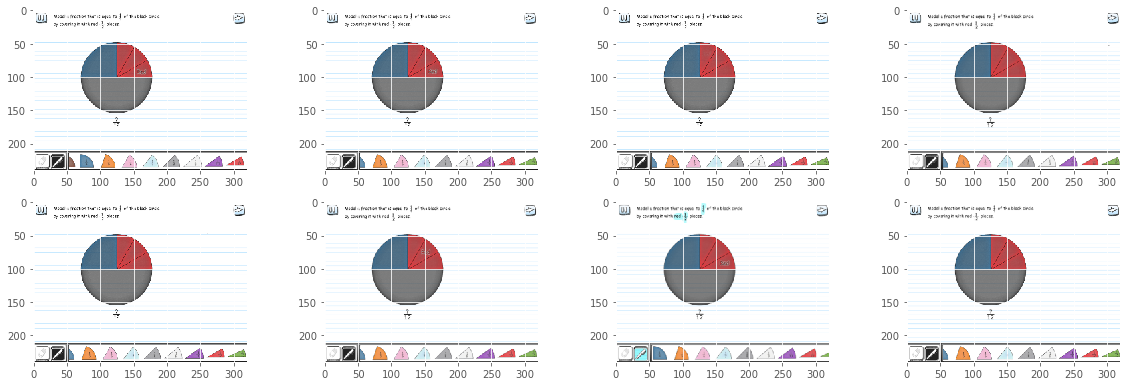

Cluster 2
                            _id behavioral_traits  bonus  correct  diff  \
4837   5a00fe819100de1a3935d5e4                []   True    False   0.5   
11834  5a0116519100de1a3994f5a3                []   True    False   0.5   
12850  5a01180f9100de1a399bebf8                []   True    False   0.5   
242    5a00f1eb9100de1a3901eda7                []   True    False   0.5   
6797   5a01042e9100de1a394cc3a3                []   True    False   0.5   
4612   5a00fdd29100de1a39331cdd                []   True    False   0.5   
6680   5a0103d19100de1a394b4b57                []   True    False   0.5   
13208  5a0118a29100de1a399e3e0f                []   True    False   0.5   
12961  5a01183d9100de1a399caa52                []   True    False   0.5   
6846   5a0104639100de1a394d95a8                []   True    False   0.5   

               id  incomplete          lesson  \
4837   OG_XxtbnEa       False  model_symbol_5   
11834  OG_XxtbnEa       False  model_symbol_5   
12850  OG_XxtbnEa

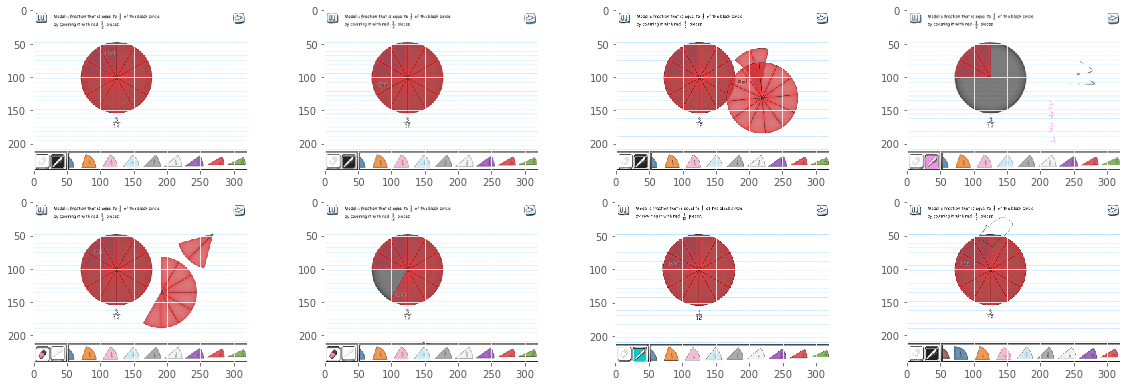

Cluster 3
                           _id behavioral_traits  bonus  correct  diff  \
7491  5a0106599100de1a39556e90                []   True    False   0.5   
7156  5a01054e9100de1a395146e0                []   True    False   0.5   
7110  5a0105249100de1a3950a1a7                []   True    False   0.5   
6918  5a0104909100de1a394e50c1                []   True    False   0.5   
6908  5a0104839100de1a394e195e                []   True    False   0.5   
6824  5a01044a9100de1a394d2fde                []   True    False   0.5   
6779  5a01041a9100de1a394c7463                []   True    False   0.5   
6778  5a0104199100de1a394c6fbf                []   True    False   0.5   
6745  5a0104009100de1a394c0b80                []   True    False   0.5   
6736  5a0103f59100de1a394bde38                []   True    False   0.5   

              id  incomplete          lesson  \
7491  OG_XxtbnEa       False  model_symbol_5   
7156  OG_XxtbnEa       False  model_symbol_5   
7110  OG_XxtbnEa       False  m

Cluster 5
                           _id behavioral_traits  bonus  correct  diff  \
2     5a00f17c9100de1a39002942                []   True    False   0.5   
4932  5a00febd9100de1a3936cb7f                []   True    False   0.5   
9720  5a010fae9100de1a397a757a                []   True    False   0.5   
4880  5a00fe939100de1a39361f15                []   True    False   0.5   
4872  5a00fe939100de1a39361cfa                []   True    False   0.5   
9764  5a0110129100de1a397c0992                []   True    False   0.5   
4859  5a00fe8e9100de1a39360a17                []   True    False   0.5   
9787  5a01102a9100de1a397c6903                []   True    False   0.5   
4827  5a00fe7d9100de1a3935c49f                []   True    False   0.5   
9804  5a0110489100de1a397ce234                []   True    False   0.5   

              id  incomplete          lesson  \
2     OG_XxtbnEa       False  model_symbol_5   
4932  OG_XxtbnEa       False  model_symbol_5   
9720  OG_XxtbnEa       False  m

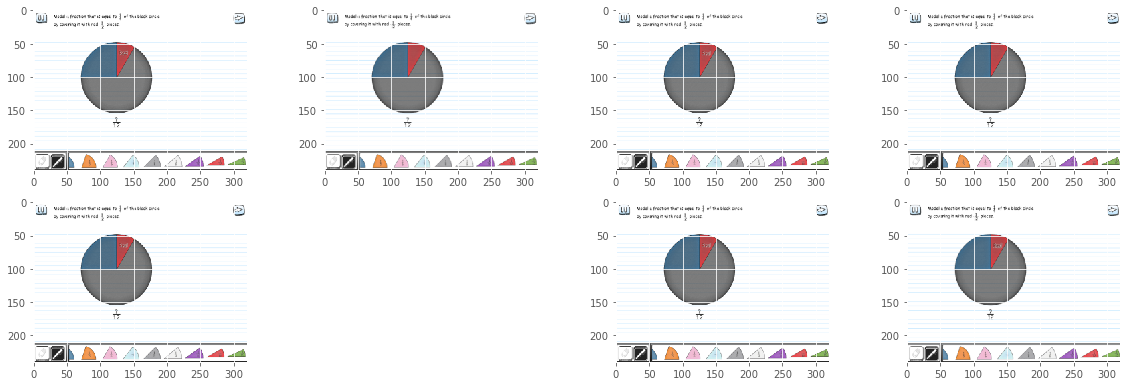

Analysis 1 for qual_id YN4n4X5GRF.bonus.Q5XY-9tBFu with 19100 samples
Session 0 txt  Model a fraction that is equal to 1/2 using the one twelfth red pieces.
Answer: [object Object]
Extracting tf-idf features ...
done in 2.595s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.180s
qual_id YN4n4X5GRF.bonus.Q5XY-9tBFu has these clusters
2    762
5    757
0    638
8    616
6    605
1    549
7    482
3    294
9    243
4    121
Name: cluster, dtype: int64
Distances (5067, 10) [[ 1.13646618  0.25040561  1.25591618 ...,  1.27657788  1.27898391
   1.21743526]
 [ 1.17044961  0.43928794  1.30251645 ...,  1.28748653  1.32208009
   1.28535183]
 [ 0.75175613  1.24041659  0.1784854  ...,  0.90929442  0.49501807
   0.89325655]
 ..., 
 [ 0.74489302  1.21575778  0.49624709 ...,  0.93638886  0.

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct  diff  \
2     5a00f17c9100de1a39002c40                []   True    False     1   
1801  5a00fd909100de1a3932152f                []   True    False     1   
1800  5a00fd8e9100de1a39320c41                []   True    False     1   
1787  5a00fd7e9100de1a3931cf40                []   True    False     1   
1784  5a00fd7e9100de1a3931ce69                []   True    False     1   
1771  5a00fd559100de1a393123c7                []   True    False     1   
1761  5a00fd3b9100de1a3930bb55                []   True    False     1   
1760  5a00fd379100de1a3930aa3d                []   True    False     1   
1759  5a00fd349100de1a39309e66                []   True    False     1   
1755  5a00fd2e9100de1a39308708                []   True    False     1   

              id  incomplete             lesson  \
2     Q5XY-9tBFu       False  model_symbol_3_v3   
1801  Q5XY-9tBFu       False  model_symbol_3_v3   
1800  Q5XY-9tBFu       False  mo

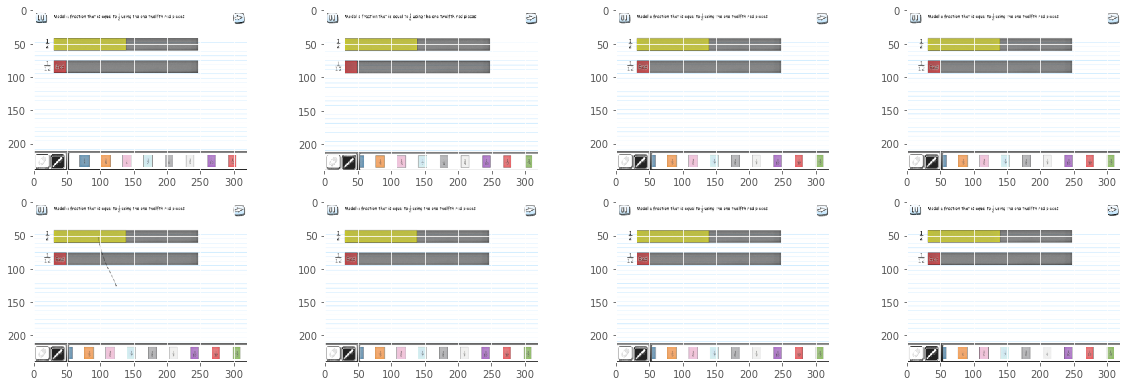

Cluster 5
                           _id behavioral_traits  bonus  correct  diff  \
769   5a00f6119100de1a39130560                []   True    False     1   
2336  5a0101bd9100de1a3942dd4a                []   True    False     1   
703   5a00f5a39100de1a391116e8                []   True    False     1   
2337  5a0101c39100de1a3942f7df                []   True    False     1   
2409  5a0102489100de1a3945173d                []   True    False     1   
3609  5a0110609100de1a397d4431                []   True    False     1   
729   5a00f5d89100de1a391208b9                []   True    False     1   
3599  5a0110399100de1a397ca75e                []   True    False     1   
3592  5a01101b9100de1a397c30d6                []   True    False     1   
1663  5a00fc849100de1a392dce40                []   True    False     1   

              id  incomplete             lesson  \
769   Q5XY-9tBFu       False  model_symbol_3_v3   
2336  Q5XY-9tBFu       False  model_symbol_3_v3   
703   Q5XY-9tBFu      

Cluster 0
                           _id behavioral_traits  bonus  correct  diff  \
4942  5a0119639100de1a39a14e54                []   True    False     1   
69    5a00f1de9100de1a3901b6fd                []   True    False     1   
2647  5a01040b9100de1a394c3749                []   True    False     1   
797   5a00f62f9100de1a3913883d                []   True    False     1   
3842  5a0113909100de1a3989efd2                []   True    False     1   
3059  5a0108fe9100de1a395fe7fe                []   True    False     1   
4804  5a0118909100de1a399df5b8                []   True    False     1   
2654  5a01041a9100de1a394c73f4                []   True    False     1   
3311  5a010bf39100de1a396ba383                []   True    False     1   
989   5a00f7639100de1a3918e6a6                []   True    False     1   

              id  incomplete             lesson  \
4942  Q5XY-9tBFu       False  model_symbol_3_v3   
69    Q5XY-9tBFu       False  model_symbol_3_v3   
2647  Q5XY-9tBFu      

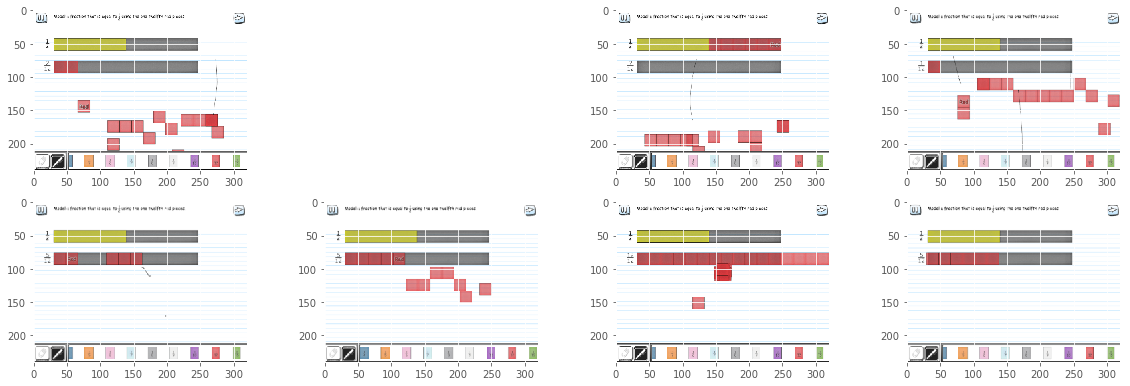

Cluster 8
                           _id behavioral_traits  bonus  correct  diff  \
2355  5a0101e59100de1a39437f67                []   True    False     1   
4149  5a0115769100de1a3991885f                []   True    False     1   
4144  5a0115779100de1a39918e56                []   True    False     1   
4141  5a01156b9100de1a39915e6f                []   True    False     1   
4110  5a01154f9100de1a3990ebd1                []   True    False     1   
4109  5a01154f9100de1a3990ebb5                []   True    False     1   
4101  5a0115449100de1a3990c098                []   True    False     1   
4094  5a0115449100de1a3990be51                []   True    False     1   
4090  5a01153f9100de1a3990ab35                []   True    False     1   
4089  5a01153e9100de1a3990a735                []   True    False     1   

              id  incomplete             lesson  \
2355  Q5XY-9tBFu       False  model_symbol_3_v3   
4149  Q5XY-9tBFu       False  model_symbol_3_v3   
4144  Q5XY-9tBFu      

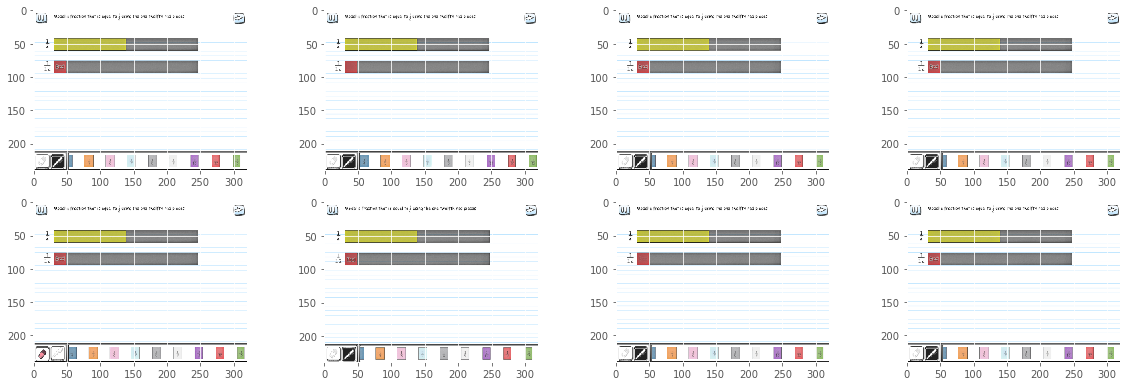

Analysis 2 for qual_id 9wRCzK1G7F.partb.12d_Yq8M01 with 18911 samples
Session 0 txt  The brown is the whole unit. Which of these pieces is one third of the brown piece?
Drag the piece to the answer box.
Answer: 1/9
Extracting tf-idf features ...
done in 0.755s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.156s
qual_id 9wRCzK1G7F.partb.12d_Yq8M01 has these clusters
4    1181
3     803
5     666
2     499
1     466
6     274
0     246
9     209
8     206
7     114
Name: cluster, dtype: int64
Distances (4664, 10) [[ 1.30723488  0.77823021  1.35767572 ...,  1.30392646  0.69118066
   1.17940628]
 [ 1.23474716  1.31291546  1.30172633 ...,  1.24068315  1.12096494
   1.15307852]
 [ 0.8660074   0.88823501  0.93744904 ...,  0.85982016  0.6081635
   0.68680117]
 ..., 
 [ 1.26811627  

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct      diff  \
3     5a00f1789100de1a39001a86                []  False    False  0.533908   
2997  5a010bce9100de1a396b11e9                []  False    False  0.533908   
2998  5a010bd49100de1a396b2924                []  False    False  0.533908   
3002  5a010bd89100de1a396b36be                []  False    False  0.533908   
3003  5a010bd59100de1a396b2dbe                []  False    False  0.533908   
3008  5a010be79100de1a396b715c                []  False    False  0.533908   
3012  5a010be39100de1a396b63e7                []  False    False  0.533908   
3015  5a010bf69100de1a396bafa5                []  False    False  0.533908   
3024  5a010c099100de1a396bfc9d                []  False    False  0.533908   
3037  5a010c309100de1a396c9324                []  False    False  0.533908   

              id  incomplete           lesson  \
3     12d_Yq8M01       False  name_fract_1_v2   
2997  12d_Yq8M01       False  name_fract_1_

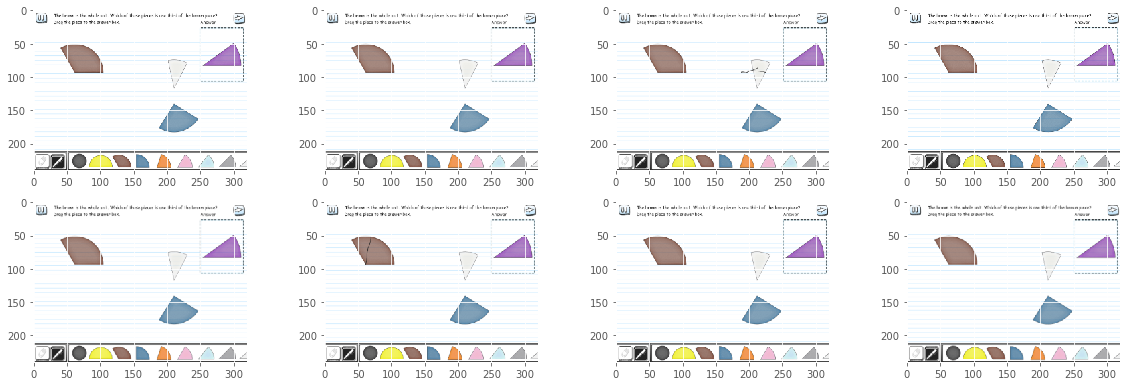

Cluster 3
                           _id behavioral_traits  bonus  correct      diff  \
6     5a00f17a9100de1a39002260                []  False    False  0.533908   
2655  5a0108a89100de1a395e9323                []  False    False  0.533908   
2628  5a01083c9100de1a395ce512                []  False    False  0.533908   
2626  5a01083a9100de1a395cdc12                []  False    False  0.533908   
2607  5a0107dc9100de1a395b65fd                []  False    False  0.533908   
2596  5a0107cc9100de1a395b26fe                []  False    False  0.533908   
2582  5a01079c9100de1a395a68e1                []  False    False  0.533908   
2580  5a01079b9100de1a395a6412                []  False    False  0.533908   
2573  5a0107829100de1a395a0515                []  False    False  0.533908   
2567  5a0107799100de1a3959e16e                []  False    False  0.533908   

              id  incomplete           lesson  \
6     12d_Yq8M01       False  review_lesson_1   
2655  12d_Yq8M01       False  nam

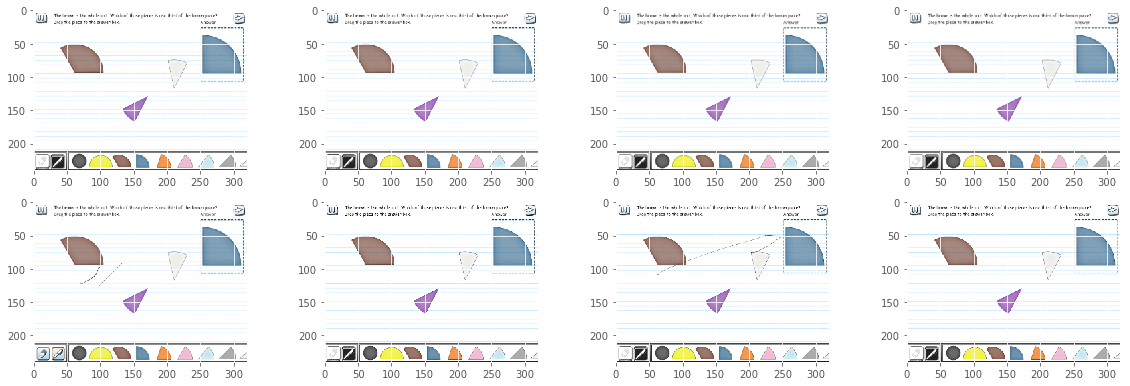

Cluster 5
                           _id behavioral_traits  bonus  correct      diff  \
4660  59d27006d0cd262c1b00c2b0               NaN  False    False  0.533908   
1691  5a00ff4e9100de1a3939144c                []  False    False  0.533908   
1703  5a00ff709100de1a3939a002                []  False    False  0.533908   
1833  5a0100869100de1a393df1cf                []  False    False  0.533908   
1861  5a0100c79100de1a393ef389                []  False    False  0.533908   
1875  5a0100e09100de1a393f578f                []  False    False  0.533908   
1914  5a01013b9100de1a3940ce5c                []  False    False  0.533908   
1920  5a0101519100de1a394127d2                []  False    False  0.533908   
1939  5a0101899100de1a39420b3b                []  False    False  0.533908   
1948  5a0101949100de1a39423718                []  False    False  0.533908   

              id  incomplete           lesson  \
4660  12d_Yq8M01       False  name_fract_1_v2   
1691  12d_Yq8M01       False  rev

Cluster 2
                           _id behavioral_traits  bonus  correct      diff  \
4639  59d26ff9d0cd262c1b0088d2               NaN  False    False  0.533908   
3281  5a010fe19100de1a397b4279                []  False    False  0.533908   
1721  5a00ffa39100de1a393a6cb8                []  False    False  0.533908   
1718  5a00ff9e9100de1a393a5646                []  False    False  0.533908   
3285  5a010ff89100de1a397ba28b                []  False    False  0.533908   
1687  5a00ff479100de1a3938f795                []  False    False  0.533908   
3292  5a01100c9100de1a397bf2a0                []  False    False  0.533908   
3296  5a0110239100de1a397c4e04                []  False    False  0.533908   
1653  5a00feec9100de1a39378b3d                []  False    False  0.533908   
3304  5a0110919100de1a397e07a8                []  False    False  0.533908   

              id  incomplete           lesson  \
4639  12d_Yq8M01       False  name_fract_1_v2   
3281  12d_Yq8M01       False  nam

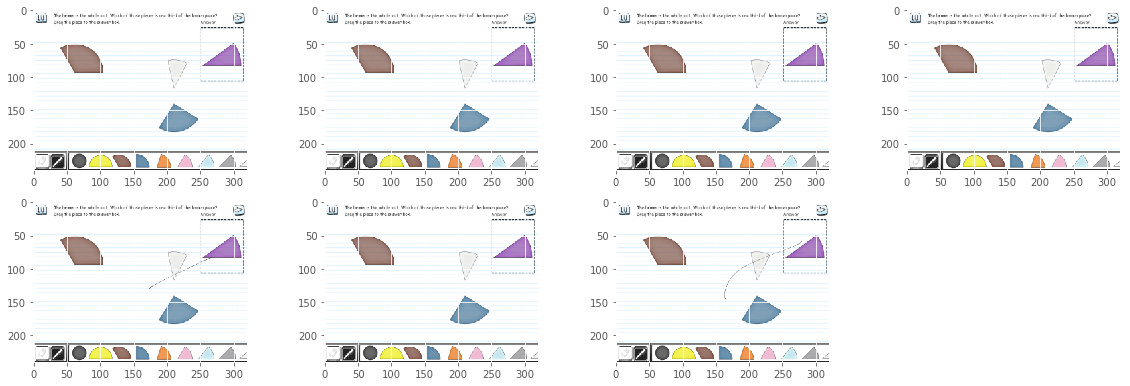

Analysis 3 for qual_id TJxldqZMXd.partb.gqJqOrIhu_ with 18390 samples
Session 0 txt  Drag one sixth pieces to cover all of the  2/3  shown.
Answer: 4
Extracting tf-idf features ...
done in 0.586s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.171s
qual_id TJxldqZMXd.partb.gqJqOrIhu_ has these clusters
3    525
9    363
1    349
7    307
8    255
2    243
4    224
6    196
5    122
0     92
Name: cluster, dtype: int64
Distances (2676, 10) [[ 0.92192859  0.91268775  0.95788151 ...,  0.75531589  0.81683753
   0.78670656]
 [ 0.92764071  0.95683228  0.95079065 ...,  0.95352634  0.99241893
   0.89599241]
 [ 0.89853453  0.88002845  0.95167276 ...,  0.74352556  0.79979602
   0.7722794 ]
 ..., 
 [ 0.8638884   0.32373556  0.95080286 ...,  0.70170333  0.45630193
   0.55432795]
 [ 0.84

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct      diff  \
2     5a00f1769100de1a39000f52                []  False    False  0.272173   
1519  5a0105309100de1a3950cffe                []  False    False  0.272173   
1514  5a0105109100de1a39505191                []  False    False  0.272173   
1510  5a0104ea9100de1a394fba8c                []  False    False  0.272173   
1509  5a0104ea9100de1a394fba8b                []  False    False  0.272173   
1500  5a0104d89100de1a394f70b9                []  False    False  0.272173   
1484  5a01049c9100de1a394e80b4                []  False    False  0.272173   
1483  5a01049c9100de1a394e80b3                []  False    False  0.272173   
1479  5a0104979100de1a394e6a5a                []  False    False  0.272173   
1474  5a0104899100de1a394e3322                []  False    False  0.272173   

              id  incomplete          lesson  \
2     gqJqOrIhu_       False  model_symbol_6   
1519  gqJqOrIhu_       False  model_symbol_6 

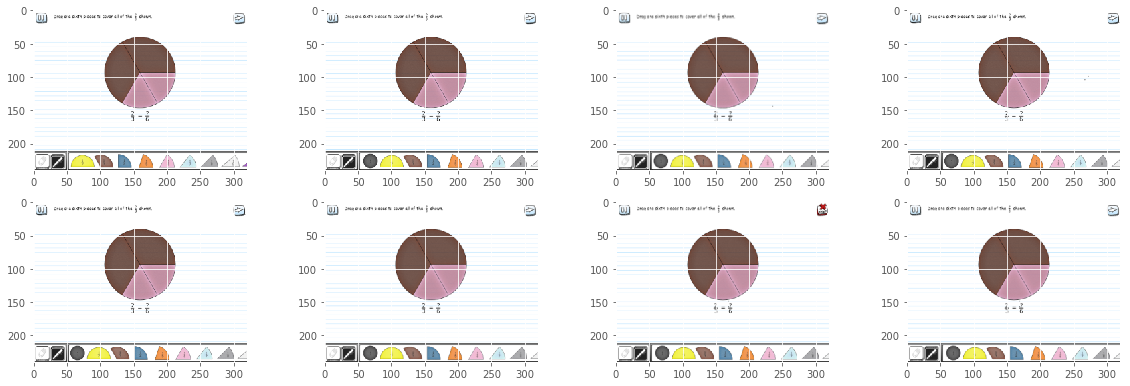

Cluster 9
                           _id behavioral_traits  bonus  correct      diff  \
2080  5a010e139100de1a397414fd                []  False    False  0.272173   
2079  5a010e139100de1a397414fc                []  False    False  0.272173   
521   5a00f7b49100de1a391a5f34                []  False    False  0.272173   
87    5a00f2879100de1a390461ae                []  False    False  0.272173   
668   5a00f9dc9100de1a39232b9e                []  False    False  0.272173   
2230  5a0111b59100de1a39829997                []  False    False  0.272173   
2661  5a0119cc9100de1a39a2ebc9                []  False    False  0.272173   
2296  5a0114319100de1a398c7392                []  False    False  0.272173   
2404  5a0115819100de1a3991b3a7                []  False    False  0.272173   
393   5a00f6469100de1a3913e9e8                []  False    False  0.272173   

              id  incomplete           lesson  \
2080  gqJqOrIhu_       False   model_symbol_6   
2079  gqJqOrIhu_       False   mo

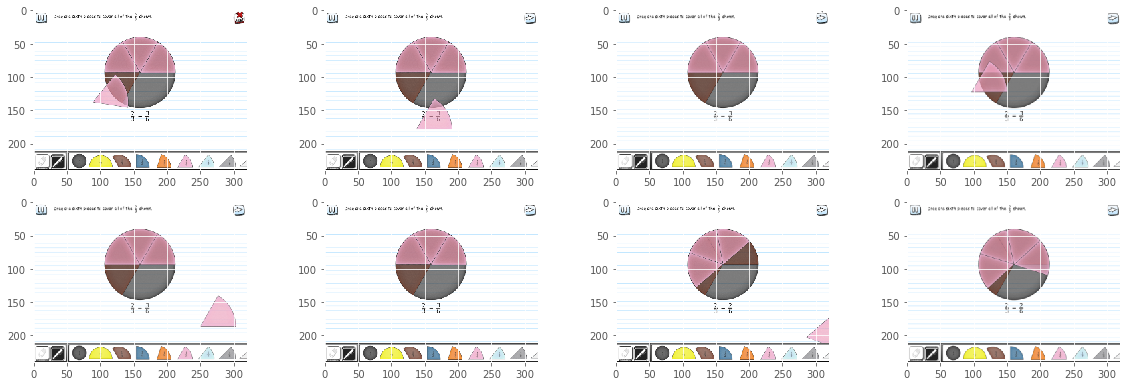

Cluster 1
                           _id behavioral_traits  bonus  correct      diff  \
10    5a00f17d9100de1a39002e91                []  False    False  0.272173   
1259  5a0102439100de1a39450099                []  False    False  0.272173   
1314  5a0102d39100de1a39474b80                []  False    False  0.272173   
1317  5a0102ec9100de1a3947b2f5                []  False    False  0.272173   
1334  5a0103079100de1a39481f35                []  False    False  0.272173   
1354  5a0103479100de1a39491cec                []  False    False  0.272173   
1355  5a0103479100de1a39491ced                []  False    False  0.272173   
1364  5a0103529100de1a39494640                []  False    False  0.272173   
1379  5a0103669100de1a39499528                []  False    False  0.272173   
1451  5a0104499100de1a394d2e16                []  False    False  0.272173   

              id  incomplete          lesson  \
10    gqJqOrIhu_       False  model_symbol_6   
1259  gqJqOrIhu_       False  model

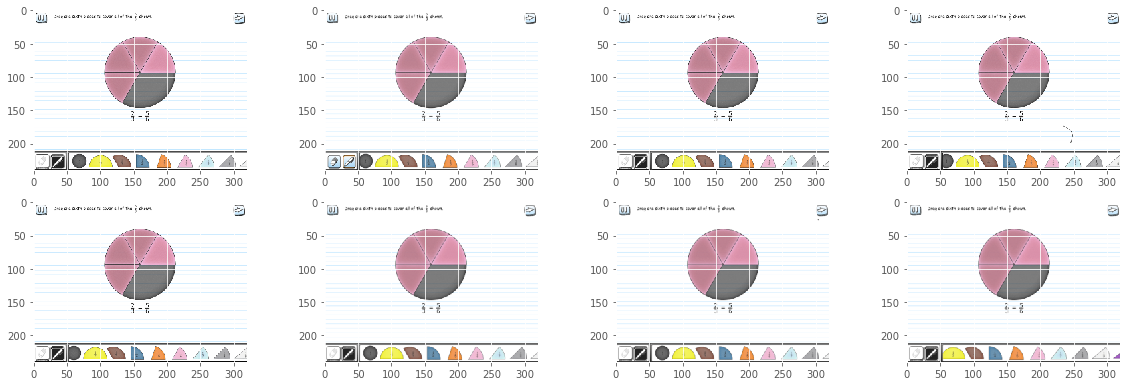

Cluster 7
                           _id behavioral_traits  bonus  correct      diff  \
1287  5a01027f9100de1a3945f4da                []  False    False  0.272173   
892   5a00fd6f9100de1a39318eee                []  False    False  0.272173   
926   5a00fdf29100de1a39339a71                []  False    False  0.272173   
2102  5a010e809100de1a3975c88e                []  False    False  0.272173   
974   5a00fe909100de1a3936129b                []  False    False  0.272173   
980   5a00fe929100de1a393618fb                []  False    False  0.272173   
2087  5a010e3c9100de1a3974be6a                []  False    False  0.272173   
997   5a00febd9100de1a3936c8bd                []  False    False  0.272173   
1002  5a00fecf9100de1a3937138c                []  False    False  0.272173   
1013  5a00fefa9100de1a3937c4ad                []  False    False  0.272173   

              id  incomplete           lesson  \
1287  gqJqOrIhu_       False   model_symbol_6   
892   gqJqOrIhu_       False   mo

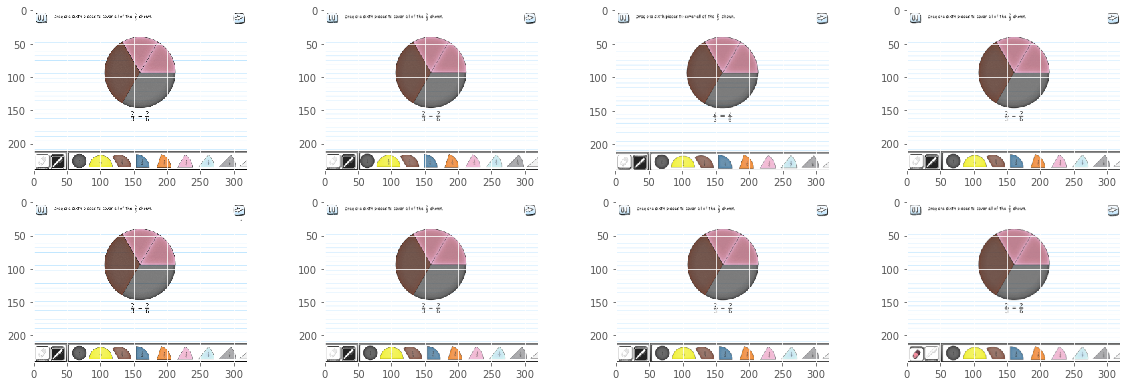

Analysis 4 for qual_id TJxldqZMXd.partb.9L_iTwGd5z with 18197 samples
Session 0 txt  Drag one eighth pieces to cover all of the  3/4  shown.
Answer: 6
Extracting tf-idf features ...
done in 0.414s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.068s
qual_id TJxldqZMXd.partb.9L_iTwGd5z has these clusters
1    1014
6     297
4     216
2     193
5     174
0     155
3     139
8     114
7      73
9      48
Name: cluster, dtype: int64
Distances (2423, 10) [[ 0.80776733  0.92224432  0.55528124 ...,  0.95533084  0.78080682
   1.084683  ]
 [ 0.95869921  1.13532524  0.34399241 ...,  0.94903698  0.83691381
   1.05370349]
 [ 0.77533308  0.93643951  0.52225189 ...,  0.91599643  0.76227366
   1.04481933]
 ..., 
 [ 0.8069466   0.92130254  0.7660125  ...,  0.92877336  0.77977295
   1.046245

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct      diff  \
658   5a00fad89100de1a39272a12                []  False    False  0.886537   
2394  5a01197b9100de1a39a1aa95                []  False    False  0.886537   
1048  5a0100219100de1a393c608d                []  False    False  0.886537   
2388  5a0119639100de1a39a14f88                []  False    False  0.886537   
1328  5a01044e9100de1a394d3e37                []  False    False  0.886537   
42    5a00f1e79100de1a3901dec9                []  False    False  0.886537   
355   5a00f61a9100de1a39132e03                []  False    False  0.886537   
361   5a00f62a9100de1a39137455                []  False    False  0.886537   
362   5a00f6489100de1a3913f26d                []  False    False  0.886537   
369   5a00f65e9100de1a39144a72                []  False    False  0.886537   

              id  incomplete           lesson  \
658   9L_iTwGd5z       False  review_lesson_2   
2394  9L_iTwGd5z       False   model_symbol

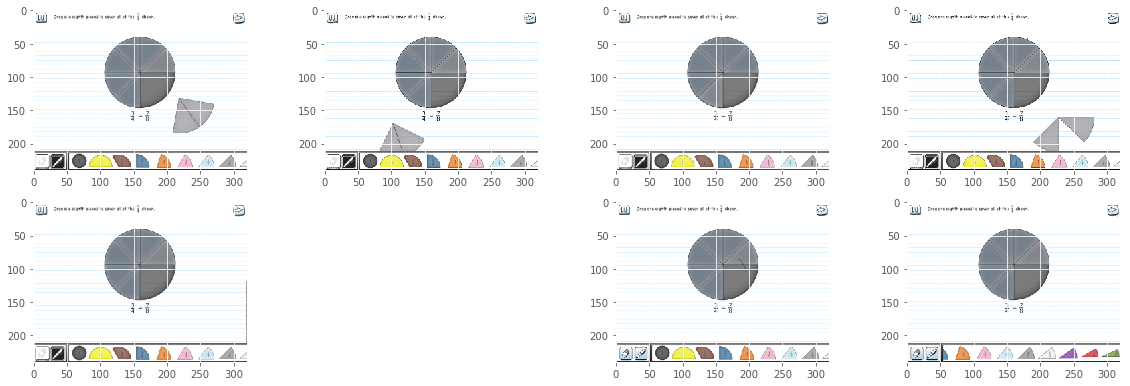

Cluster 6
                           _id behavioral_traits  bonus  correct      diff  \
1637  5a0109c49100de1a3962f0da                []  False    False  0.886537   
1463  5a0106a59100de1a39569f93                []  False    False  0.886537   
1733  5a010b5b9100de1a39694833                []  False    False  0.886537   
429   5a00f7409100de1a391856b5                []  False    False  0.886537   
2224  5a0116169100de1a39940754                []  False    False  0.886537   
1443  5a0106449100de1a39551884                []  False    False  0.886537   
1241  5a01034e9100de1a3949365d                []  False    False  0.886537   
720   5a00fbca9100de1a392af639                []  False    False  0.886537   
2194  5a01155b9100de1a39911ca1                []  False    False  0.886537   
1545  5a0108239100de1a395c7d17                []  False    False  0.886537   

              id  incomplete           lesson  \
1637  9L_iTwGd5z       False   model_symbol_6   
1463  9L_iTwGd5z       False   mo

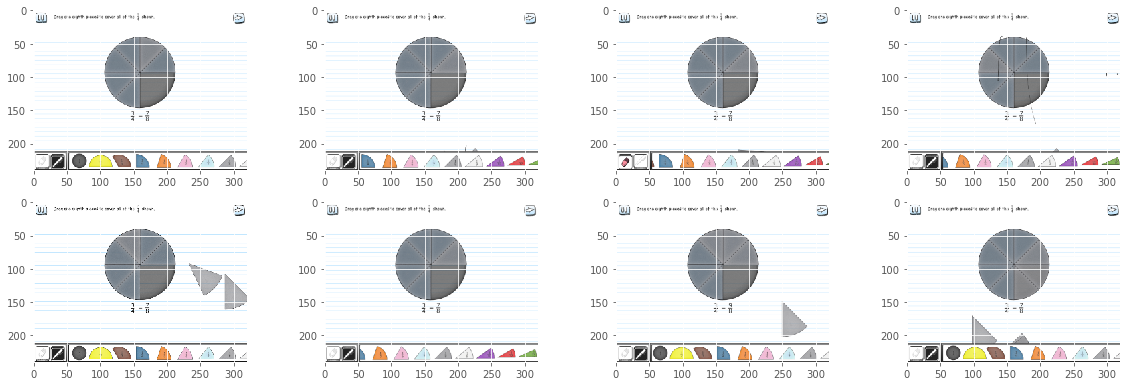

Cluster 4
                           _id behavioral_traits  bonus  correct      diff  \
25    5a00f1c59100de1a390156c0                []  False    False  0.886537   
1521  5a0107b49100de1a395ac80c                []  False    False  0.886537   
1539  5a0108129100de1a395c3851                []  False    False  0.886537   
1541  5a01081c9100de1a395c6146                []  False    False  0.886537   
1550  5a0108399100de1a395cd79f                []  False    False  0.886537   
1557  5a0108609100de1a395d743d                []  False    False  0.886537   
1564  5a0108729100de1a395dba13                []  False    False  0.886537   
1585  5a0108bb9100de1a395edb57                []  False    False  0.886537   
1603  5a0108ee9100de1a395fa71b                []  False    False  0.886537   
1611  5a01093a9100de1a3960d2b8                []  False    False  0.886537   

              id  incomplete          lesson  \
25    9L_iTwGd5z       False  model_symbol_6   
1521  9L_iTwGd5z       False  model

Cluster 2
                           _id behavioral_traits  bonus  correct      diff  \
1321  5a01041b9100de1a394c75b8                []  False    False  0.886537   
473   5a00f8029100de1a391bb1e4                []  False    False  0.886537   
1504  5a01076d9100de1a3959b40f                []  False    False  0.886537   
1150  5a0101fc9100de1a3943df19                []  False    False  0.886537   
1149  5a0101fc9100de1a3943df18                []  False    False  0.886537   
1072  5a01009b9100de1a393e44b7                []  False    False  0.886537   
1038  5a01000e9100de1a393c1576                []  False    False  0.886537   
934   5a00feb49100de1a3936a289                []  False    False  0.886537   
875   5a00fe0b9100de1a3933fee0                []  False    False  0.886537   
1     5a00f17b9100de1a39002562                []  False    False  0.886537   

              id  incomplete           lesson  \
1321  9L_iTwGd5z       False   model_symbol_6   
473   9L_iTwGd5z       False  rev

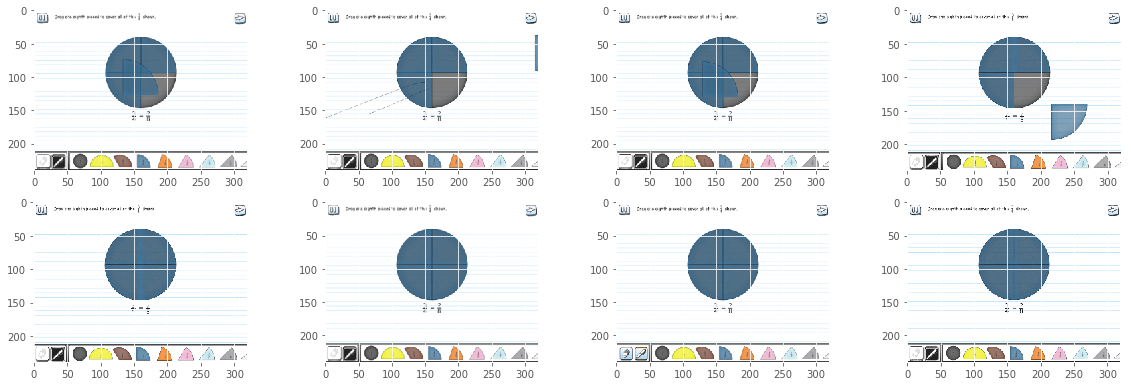

Analysis 5 for qual_id TJxldqZMXd.partb.W2tLvQTbkI with 17800 samples
Session 0 txt  Drag one half pieces to cover all of the  2/4  shown.
Answer: 1
Extracting tf-idf features ...
done in 0.428s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.238s
qual_id TJxldqZMXd.partb.W2tLvQTbkI has these clusters
4    715
3    309
1    272
6    240
2    206
8    168
0    141
5    138
9     56
7     47
Name: cluster, dtype: int64
Distances (2292, 10) [[ 0.91803803  0.93902528  0.78164773 ...,  0.9084771   0.75488925
   0.53330682]
 [ 0.87806605  0.88196565  1.09588997 ...,  1.020032    0.63109736
   0.96321812]
 [ 0.88199993  0.93619108  1.06884288 ...,  1.04471044  0.48576356
   0.84288138]
 ..., 
 [ 0.91141167  0.92899776  0.25484199 ...,  0.89806207  0.98136802
   0.8066961 ]
 [ 1.241

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct  diff  \
8     5a00f17f9100de1a39003552                []  False    False     0   
1428  5a01077e9100de1a3959f4e3                []  False    False     0   
1429  5a01077e9100de1a3959f4e4                []  False    False     0   
1432  5a01079d9100de1a395a6e2d                []  False    False     0   
1433  5a01079f9100de1a395a758c                []  False    False     0   
1434  5a01079e9100de1a395a71dc                []  False    False     0   
1441  5a0107bb9100de1a395ae442                []  False    False     0   
1445  5a0107c89100de1a395b15a5                []  False    False     0   
1460  5a0108249100de1a395c8091                []  False    False     0   
1461  5a0108239100de1a395c7d15                []  False    False     0   

              id  incomplete          lesson  \
8     W2tLvQTbkI       False  model_symbol_6   
1428  W2tLvQTbkI       False  model_symbol_6   
1429  W2tLvQTbkI       False  model_symbo

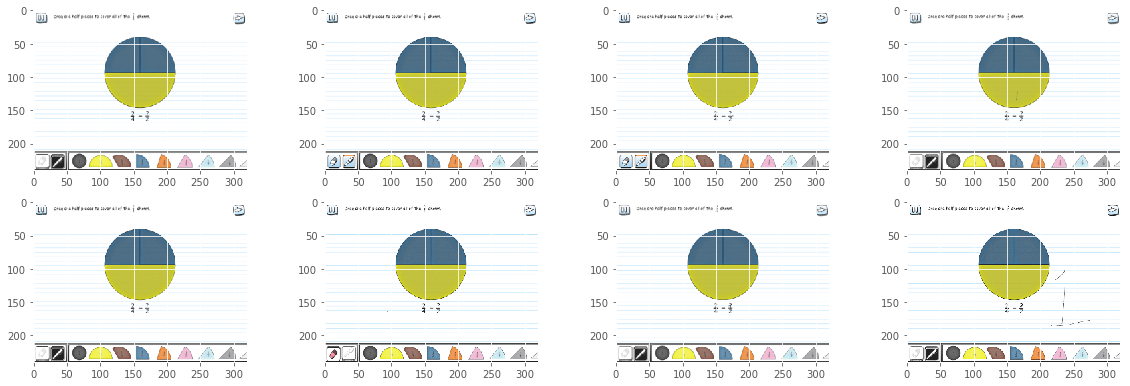

Cluster 3
                           _id behavioral_traits  bonus  correct  diff  \
0     5a00f1769100de1a39000f4f                []  False    False     0   
1177  5a0103219100de1a394887b0                []  False    False     0   
1191  5a0103499100de1a3949232b                []  False    False     0   
1205  5a01036a9100de1a3949a5ff                []  False    False     0   
1210  5a0103709100de1a3949bc7e                []  False    False     0   
1212  5a0103709100de1a3949bfea                []  False    False     0   
1218  5a0103789100de1a3949dfdd                []  False    False     0   
1227  5a01039c9100de1a394a72a4                []  False    False     0   
1247  5a0103de9100de1a394b7dc3                []  False    False     0   
1254  5a0103f09100de1a394bc838                []  False    False     0   

              id  incomplete          lesson  \
0     W2tLvQTbkI       False  model_symbol_6   
1177  W2tLvQTbkI       False  model_symbol_6   
1191  W2tLvQTbkI       False  m

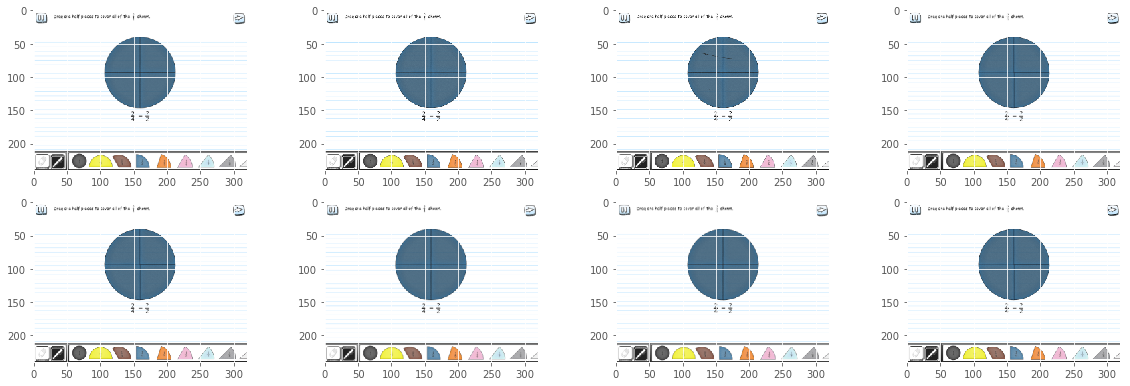

Cluster 1
                           _id behavioral_traits  bonus  correct  diff  \
1253  5a0103ec9100de1a394bb951                []  False    False     0   
1114  5a0102259100de1a394486fd                []  False    False     0   
1122  5a0102539100de1a39454279                []  False    False     0   
1123  5a0102559100de1a39454a7f                []  False    False     0   
1145  5a01029c9100de1a39466d3e                []  False    False     0   
1178  5a0103229100de1a39488940                []  False    False     0   
1864  5a0110e69100de1a397f5bf8                []  False    False     0   
1201  5a01035e9100de1a394975a1                []  False    False     0   
1203  5a0103649100de1a39498de3                []  False    False     0   
1219  5a01037c9100de1a3949f271                []  False    False     0   

              id  incomplete           lesson  \
1253  W2tLvQTbkI       False   model_symbol_6   
1114  W2tLvQTbkI       False   model_symbol_6   
1122  W2tLvQTbkI       False

Cluster 6
                           _id behavioral_traits  bonus  correct  diff  \
1640  5a010bba9100de1a396ac2f3                []  False    False     0   
1363  5a0105ba9100de1a3952f34d                []  False    False     0   
1561  5a010a0f9100de1a396421a9                []  False    False     0   
1575  5a010a729100de1a3965b51b                []  False    False     0   
494   5a00f8849100de1a391dbf3a                []  False    False     0   
1637  5a010bac9100de1a396a87cd                []  False    False     0   
1003  5a0100099100de1a393c031b                []  False    False     0   
246   5a00f4729100de1a390c1ff1                []  False    False     0   
379   5a00f6bc9100de1a3915f242                []  False    False     0   
1701  5a010c829100de1a396ddb6c                []  False    False     0   

              id  incomplete           lesson  \
1640  W2tLvQTbkI       False   model_symbol_6   
1363  W2tLvQTbkI       False   model_symbol_6   
1561  W2tLvQTbkI       False

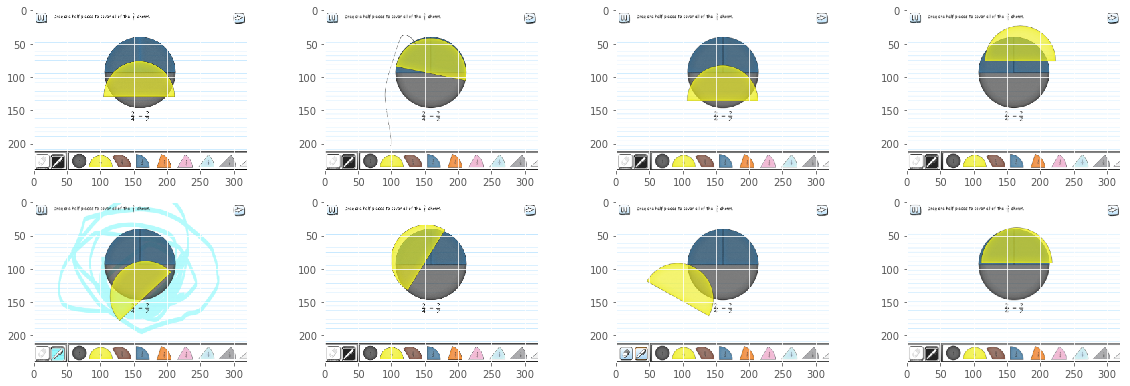

Analysis 6 for qual_id 9wRCzK1G7F.partb.SHkv5F_Yzi with 17466 samples
Session 0 txt  The orange is the whole unit. Which of these pieces is one half of the orange piece?
Drag the piece to the answer box.
Answer: 1/10
Extracting tf-idf features ...
done in 0.466s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.032s
qual_id 9wRCzK1G7F.partb.SHkv5F_Yzi has these clusters
0    1860
2    1041
6     558
3     553
7     472
1     420
5     227
9     195
4     174
8     102
Name: cluster, dtype: int64
Distances (5602, 10) [[ 1.1816681   1.20086275  0.94226662 ...,  1.13062715  1.20376853
   1.20210314]
 [ 1.35971648  1.33696511  0.96493551 ...,  1.34158149  0.78418357
   1.32077131]
 [ 0.7228359   0.76124895  0.83117138 ...,  0.70722006  1.18568966
   0.82709437]
 ..., 
 [ 0.0233202

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct      diff  \
6     5a00f1799100de1a39001ad0                []  False    False  0.620549   
3943  5a0110ef9100de1a397f7da2                []  False    False  0.620549   
3934  5a0110e49100de1a397f50a0                []  False    False  0.620549   
3927  5a0110d49100de1a397f12e4                []  False    False  0.620549   
3923  5a0110cb9100de1a397eedc1                []  False    False  0.620549   
3922  5a0110ca9100de1a397ee974                []  False    False  0.620549   
3920  5a0110c29100de1a397ec829                []  False    False  0.620549   
3916  5a0110c19100de1a397ec509                []  False    False  0.620549   
3915  5a0110c19100de1a397ec4b8                []  False    False  0.620549   
3912  5a0110b89100de1a397ea093                []  False    False  0.620549   

              id  incomplete           lesson  \
6     SHkv5F_Yzi       False  name_fract_1_v2   
3943  SHkv5F_Yzi       False  name_fract_1_

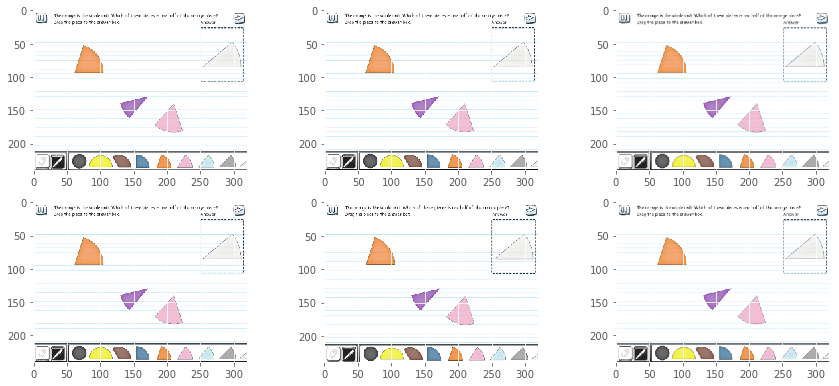

Cluster 2
                           _id behavioral_traits  bonus  correct      diff  \
2905  5a0106139100de1a395450c1                []  False    False  0.620549   
4984  5a0117429100de1a3998b911                []  False    False  0.620549   
1844  5a00fe1c9100de1a39344182                []  False    False  0.620549   
825   5a00f6859100de1a3914e958                []  False    False  0.620549   
3517  5a010bfb9100de1a396bc33e                []  False    False  0.620549   
3521  5a010c069100de1a396bf15d                []  False    False  0.620549   
3582  5a010c6b9100de1a396d805c                []  False    False  0.620549   
4980  5a0117439100de1a3998ba93                []  False    False  0.620549   
3619  5a010cc59100de1a396ee1a1                []  False    False  0.620549   
4988  5a0117479100de1a3998cb02                []  False    False  0.620549   

              id  incomplete           lesson  \
2905  SHkv5F_Yzi       False  review_lesson_1   
4984  SHkv5F_Yzi       False  nam

Cluster 6
                           _id behavioral_traits  bonus  correct      diff  \
3     5a00f1759100de1a39000a53                []  False    False  0.620549   
3346  5a010a609100de1a39656bab                []  False    False  0.620549   
3336  5a010a559100de1a39653f46                []  False    False  0.620549   
3329  5a010a349100de1a3964b891                []  False    False  0.620549   
3285  5a01099a9100de1a39624c78                []  False    False  0.620549   
3249  5a01096b9100de1a39619248                []  False    False  0.620549   
3246  5a0109629100de1a39617141                []  False    False  0.620549   
3238  5a0109529100de1a39612fef                []  False    False  0.620549   
3224  5a0109329100de1a3960b1bb                []  False    False  0.620549   
3221  5a01092d9100de1a39609d75                []  False    False  0.620549   

              id  incomplete           lesson  \
3     SHkv5F_Yzi       False  name_fract_1_v2   
3346  SHkv5F_Yzi       False  nam

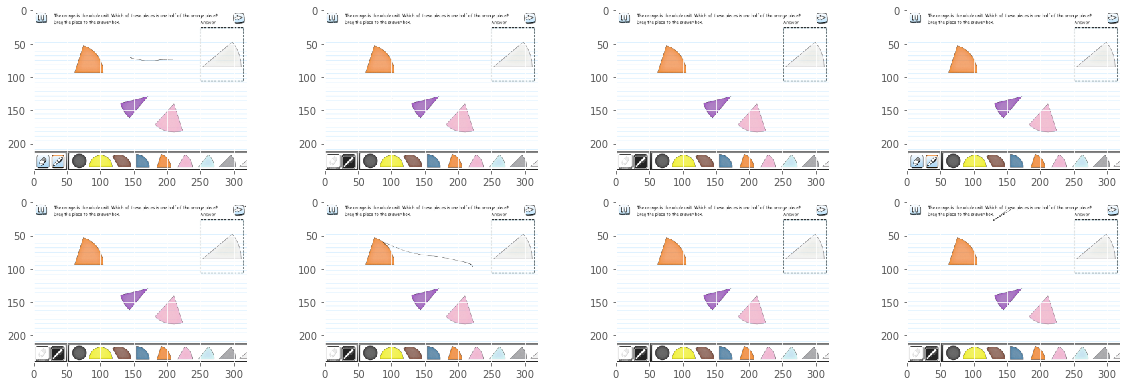

Cluster 3
                           _id behavioral_traits  bonus  correct      diff  \
1785  5a00fd929100de1a39321d89                []  False    False  0.620549   
958   5a00f7829100de1a39196fab                []  False    False  0.620549   
5     5a00f1789100de1a39001a84                []  False    False  0.620549   
3777  5a010e559100de1a39751e82                []  False    False  0.620549   
4318  5a01150d9100de1a398fe29b                []  False    False  0.620549   
3776  5a010e559100de1a39751e81                []  False    False  0.620549   
2263  5a0101309100de1a3940a393                []  False    False  0.620549   
2558  5a0103479100de1a39491d43                []  False    False  0.620549   
4972  5a01172f9100de1a39986a5d                []  False    False  0.620549   
4394  5a01152c9100de1a39905d9d                []  False    False  0.620549   

              id  incomplete           lesson  \
1785  SHkv5F_Yzi       False  name_fract_1_v2   
958   SHkv5F_Yzi       False  nam

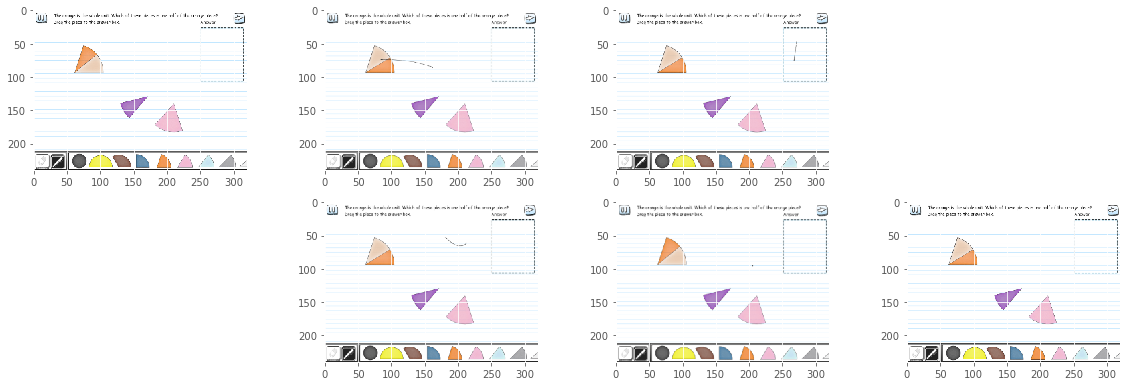

Analysis 7 for qual_id TJxldqZMXd.partb.hxS1eqLik1 with 17191 samples
Session 0 txt  Drag one half pieces to cover all of the  4/8  shown.
Answer: 1
Extracting tf-idf features ...
done in 0.115s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.059s
qual_id TJxldqZMXd.partb.hxS1eqLik1 has these clusters
3    265
4    244
5    152
2    135
1     86
6     72
7     42
8     30
0     19
9     13
Name: cluster, dtype: int64
Distances (1058, 10) [[ 1.08707247  0.49840186  0.65302107 ...,  0.8983707   0.87054592
   0.77348319]
 [ 1.08406509  0.50732095  0.69201439 ...,  0.89543241  0.8824415
   0.7566718 ]
 [ 1.13167274  0.59032761  0.62501684 ...,  0.94001342  0.87822044
   0.9134809 ]
 ..., 
 [ 1.14554288  0.7292056   0.74453252 ...,  0.81594538  0.83841108
   0.97001936]
 [ 0.9183

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                          _id behavioral_traits  bonus  correct  diff  \
527  5a0102a49100de1a39468ee1                []  False    False     1   
588  5a01043b9100de1a394cf566                []  False    False     1   
592  5a0104529100de1a394d5186                []  False    False     1   
595  5a0104759100de1a394de1cb                []  False    False     1   
597  5a0104869100de1a394e273d                []  False    False     1   
604  5a0104a09100de1a394e91bc                []  False    False     1   
607  5a0104b89100de1a394ef1fe                []  False    False     1   
609  5a0104b89100de1a394ef086                []  False    False     1   
610  5a0104ba9100de1a394efc2c                []  False    False     1   
612  5a0104e79100de1a394fac5c                []  False    False     1   

             id  incomplete           lesson  \
527  hxS1eqLik1       False   model_symbol_6   
588  hxS1eqLik1       False   model_symbol_6   
592  hxS1eqLik1       False  review_lesson_2   
595 

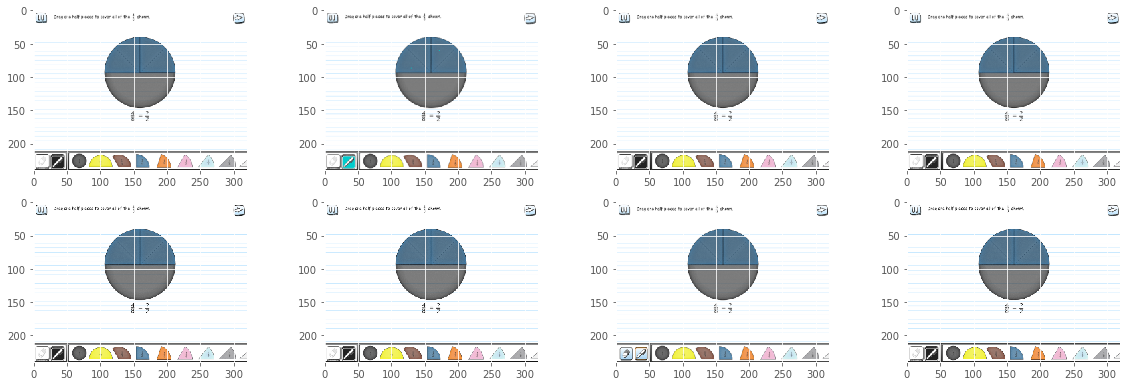

Cluster 4
                          _id behavioral_traits  bonus  correct  diff  \
12   5a00f1c59100de1a390156c1                []  False    False     1   
680  5a0107ff9100de1a395bef30                []  False    False     1   
681  5a0108129100de1a395c3852                []  False    False     1   
682  5a0108129100de1a395c387d                []  False    False     1   
686  5a0108279100de1a395c8da1                []  False    False     1   
687  5a0108399100de1a395cd7a0                []  False    False     1   
694  5a0108719100de1a395db998                []  False    False     1   
695  5a0108729100de1a395dba14                []  False    False     1   
698  5a0108bb9100de1a395edb58                []  False    False     1   
713  5a01093a9100de1a3960d2b9                []  False    False     1   

             id  incomplete          lesson  \
12   hxS1eqLik1       False  model_symbol_6   
680  hxS1eqLik1       False  model_symbol_6   
681  hxS1eqLik1       False  model_symbol_6  

Cluster 5
                          _id behavioral_traits  bonus  correct  diff  \
29   5a00f2499100de1a39036b37                []  False    False     1   
734  5a010abe9100de1a3966dff2                []  False    False     1   
729  5a010a4b9100de1a396515c6                []  False    False     1   
727  5a010a409100de1a3964e6a0                []  False    False     1   
725  5a010a379100de1a3964c53c                []  False    False     1   
719  5a0109de9100de1a39635cba                []  False    False     1   
715  5a01095f9100de1a39616372                []  False    False     1   
711  5a0109389100de1a3960c7cc                []  False    False     1   
710  5a0109219100de1a39606dab                []  False    False     1   
709  5a0109219100de1a39606daa                []  False    False     1   

             id  incomplete           lesson  \
29   hxS1eqLik1       False   model_symbol_6   
734  hxS1eqLik1       False   model_symbol_6   
729  hxS1eqLik1       False  review_lesson

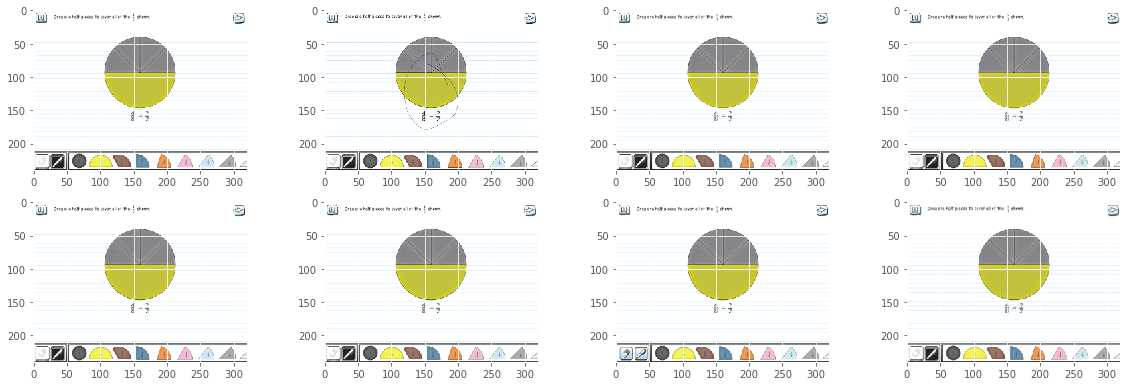

Cluster 2
                          _id behavioral_traits  bonus  correct  diff  \
633  5a0105b59100de1a3952df81                []  False    False     1   
544  5a0103249100de1a3948925e                []  False    False     1   
831  5a010f2a9100de1a3978697c                []  False    False     1   
210  5a00f7f19100de1a391b68b8                []  False    False     1   
584  5a0104149100de1a394c5a45                []  False    False     1   
714  5a0109619100de1a39616bc5                []  False    False     1   
379  5a00fdab9100de1a39328249                []  False    False     1   
644  5a0106809100de1a39560d32                []  False    False     1   
76   5a00f37a9100de1a39083796                []  False    False     1   
479  5a0100a69100de1a393e6f7d                []  False    False     1   

             id  incomplete           lesson  \
633  hxS1eqLik1       False   model_symbol_6   
544  hxS1eqLik1       False  review_lesson_2   
831  hxS1eqLik1       False   model_symbol

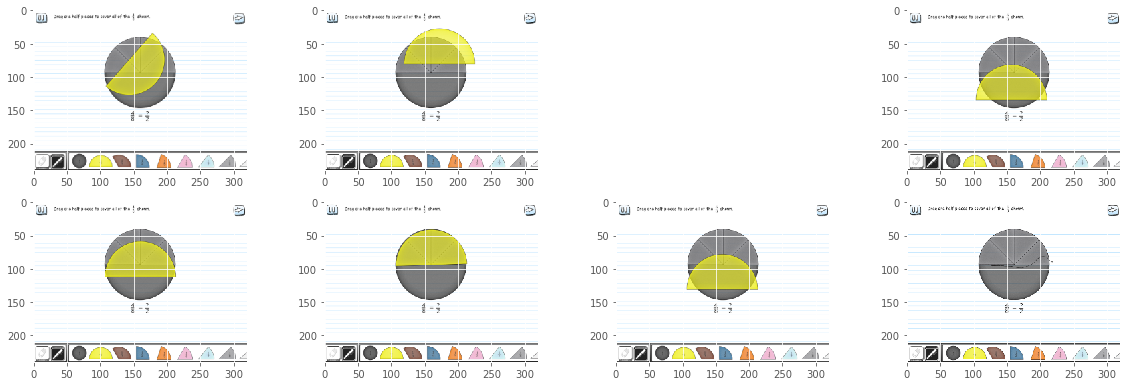

Analysis 8 for qual_id 9wRCzK1G7F.partb.qGGEQyiE_j with 17007 samples
Session 0 txt  The yellow is the whole unit. Which of these pieces is one half of the yellow piece?
Drag the piece to the answer box.
Answer: 1/4
Extracting tf-idf features ...
done in 0.312s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.072s
qual_id 9wRCzK1G7F.partb.qGGEQyiE_j has these clusters
3    1144
0     724
7     426
4     361
2     226
5     177
1     158
6     149
9     113
8      27
Name: cluster, dtype: int64
Distances (3505, 10) [[ 0.94588822  0.84845354  0.9790695  ...,  0.94522838  1.0252336
   0.98382505]
 [ 0.17702748  0.52223939  0.98575635 ...,  0.50213172  0.73219791
   0.75892092]
 [ 0.95704006  0.86060762  0.03339928 ...,  0.93184831  0.89704871
   0.8703041 ]
 ..., 
 [ 0.78332221 

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct  diff  \
2144  5a0109379100de1a3960c6f9                []  False    False     0   
2148  5a0109479100de1a39610340                []  False    False     0   
879   5a00fae89100de1a3927687b                []  False    False     0   
1783  5a0103dd9100de1a394b7b18                []  False    False     0   
862   5a00faaf9100de1a39268960                []  False    False     0   
1989  5a01066e9100de1a3955c50e                []  False    False     0   
1787  5a0103ea9100de1a394bb17f                []  False    False     0   
844   5a00fa4b9100de1a3924f41e                []  False    False     0   
2798  5a0114d79100de1a398f031f                []  False    False     0   
2799  5a0114dd9100de1a398f1cee                []  False    False     0   

              id  incomplete           lesson  \
2144  qGGEQyiE_j       False  review_lesson_1   
2148  qGGEQyiE_j       False  review_lesson_1   
879   qGGEQyiE_j       False  name_fra

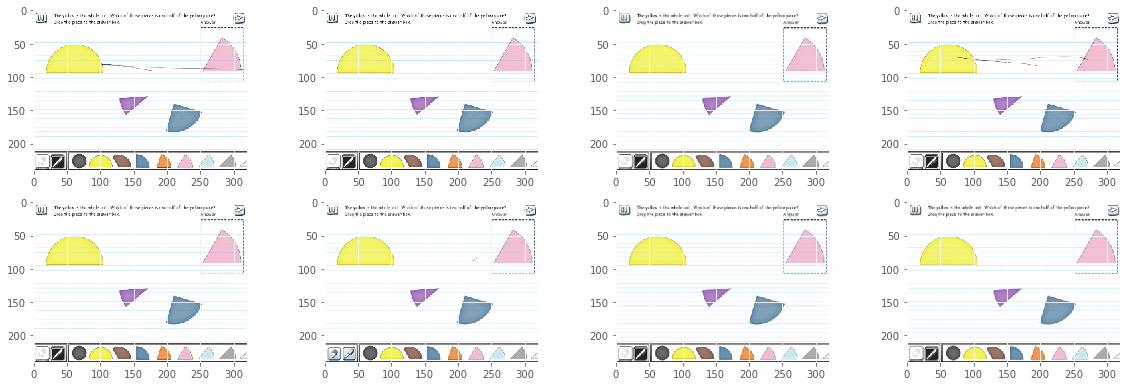

Cluster 0
                           _id behavioral_traits  bonus  correct  diff  \
1089  5a00fd269100de1a39306274                []  False    False     0   
2312  5a010b609100de1a39695a87                []  False    False     0   
930   5a00fb829100de1a3929cde5                []  False    False     0   
475   5a00f5d79100de1a39120679                []  False    False     0   
2309  5a010b5e9100de1a396953f9                []  False    False     0   
2293  5a010b1d9100de1a39685441                []  False    False     0   
2277  5a010af29100de1a3967a90c                []  False    False     0   
1294  5a00ff029100de1a3937e528                []  False    False     0   
921   5a00fb5f9100de1a39293f3c                []  False    False     0   
1329  5a00ff629100de1a3939660c                []  False    False     0   

              id  incomplete           lesson  \
1089  qGGEQyiE_j       False  name_fract_1_v2   
2312  qGGEQyiE_j       False  name_fract_1_v2   
930   qGGEQyiE_j       False

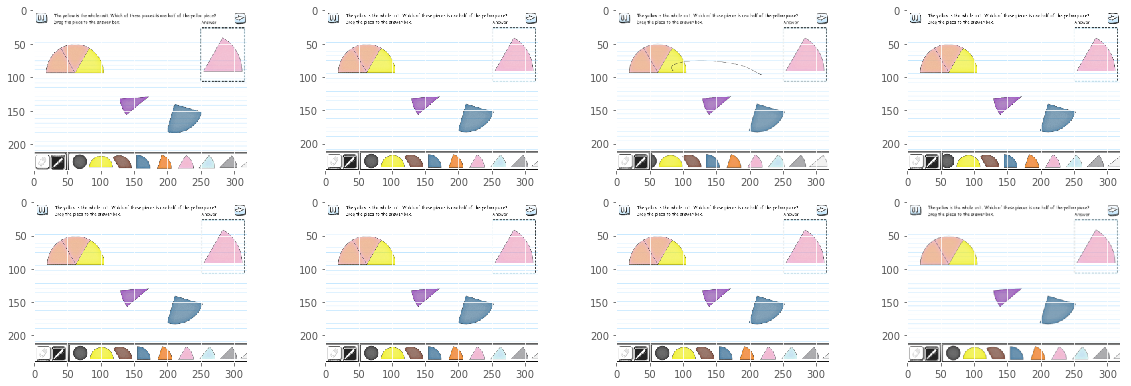

Cluster 7
                           _id behavioral_traits  bonus  correct  diff  \
2132  5a01090b9100de1a39601b69                []  False    False     0   
938   5a00fbae9100de1a392a84c1                []  False    False     0   
2151  5a01095d9100de1a39615b67                []  False    False     0   
955   5a00fbf49100de1a392b9833                []  False    False     0   
960   5a00fc179100de1a392c2007                []  False    False     0   
2114  5a0108c09100de1a395eef17                []  False    False     0   
2101  5a01087c9100de1a395de26a                []  False    False     0   
935   5a00fb989100de1a392a2c03                []  False    False     0   
992   5a00fc579100de1a392d1cd4                []  False    False     0   
1896  5a0104c09100de1a394f13b8                []  False    False     0   

              id  incomplete           lesson  \
2132  qGGEQyiE_j       False  name_fract_1_v2   
938   qGGEQyiE_j       False  name_fract_1_v2   
2151  qGGEQyiE_j       False

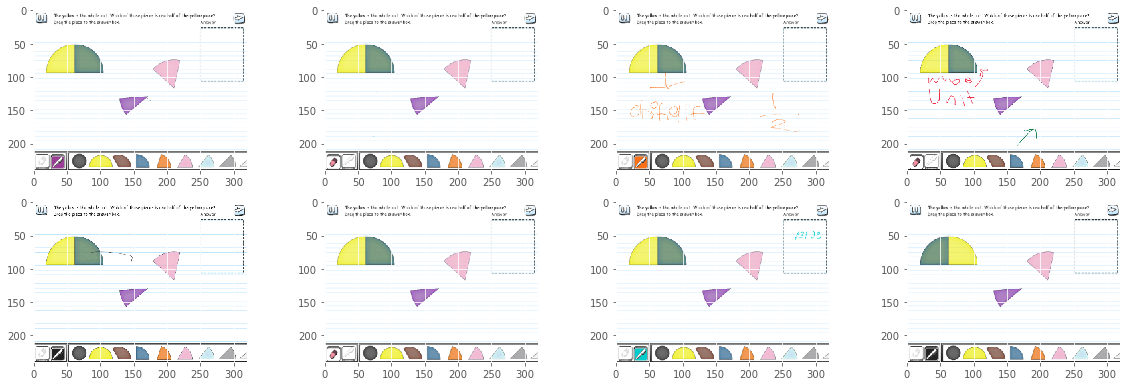

Cluster 4
                           _id behavioral_traits  bonus  correct  diff  \
2658  5a0112199100de1a39841e28                []  False    False     0   
1868  5a0104819100de1a394e11a2                []  False    False     0   
1791  5a0103ef9100de1a394bc5a3                []  False    False     0   
323   5a00f45e9100de1a390bcd78                []  False    False     0   
1597  5a0102259100de1a39448686                []  False    False     0   
1562  5a0101d99100de1a3943519c                []  False    False     0   
1493  5a0100d09100de1a393f1845                []  False    False     0   
1422  5a0100479100de1a393cf7ab                []  False    False     0   
1310  5a00ff359100de1a3938b0ee                []  False    False     0   
3080  5a0116909100de1a3995f102                []  False    False     0   

              id  incomplete           lesson  \
2658  qGGEQyiE_j       False  name_fract_1_v2   
1868  qGGEQyiE_j       False  name_fract_1_v2   
1791  qGGEQyiE_j       False

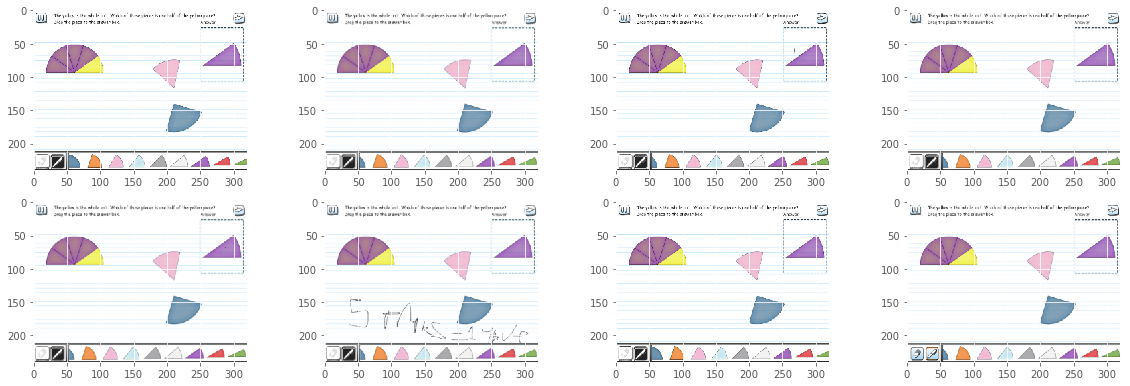

Analysis 9 for qual_id kvig7fcCVc.partb.3y7UMHuR_i with 16876 samples
Session 0 txt  Arrange these fractions from least to greatest.
Drag each fraction into one of the boxes below.
Answer: 2/8,2/6,2/4
Extracting tf-idf features ...
done in 0.669s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=62, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.081s
qual_id kvig7fcCVc.partb.3y7UMHuR_i has these clusters
2    1507
9    1080
1     171
5       7
6       6
7       5
8       4
3       2
4       2
Name: cluster, dtype: int64
Distances (2784, 10) [[  1.55092142e-01   1.00000000e+00   1.49011612e-08 ...,   1.00261468e+00
    9.85038214e-01   1.55092142e-01]
 [  1.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   9.90015328e-01
    9.87006631e-01   1.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   9.90015

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           _id behavioral_traits  bonus  correct      diff  \
0     5a00f1879100de1a39005a67                []  False    False  0.093672   
1090  5a00ff509100de1a39391d9d                []  False    False  0.093672   
1089  5a00ff469100de1a3938f54e                []  False    False  0.093672   
1088  5a00ff3d9100de1a3938cf9e                []  False    False  0.093672   
1087  5a00ff389100de1a3938beaa                []  False    False  0.093672   
1086  5a00ff369100de1a3938b4dd                []  False    False  0.093672   
1085  5a00ff2f9100de1a39389aaf                []  False    False  0.093672   
1084  5a00ff2d9100de1a39389267                []  False    False  0.093672   
1083  5a00ff1b9100de1a39384b7b                []  False    False  0.093672   
1082  5a00ff1b9100de1a39384b7a                []  False    False  0.093672   

              id  incomplete            lesson  \
0     3y7UMHuR_i       False  basic_ordering_1   
1090  3y7UMHuR_i       False    adv_order

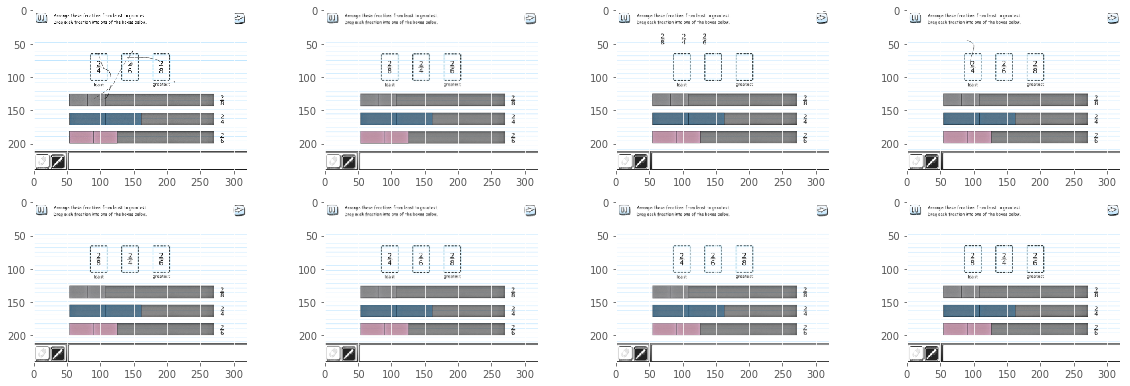

Cluster 9
                           _id behavioral_traits  bonus  correct      diff  \
1307  5a0101e89100de1a39438c1c                []  False    False  0.093672   
2384  5a0114159100de1a398c0446                []  False    False  0.093672   
2386  5a0114279100de1a398c4dc8                []  False    False  0.093672   
2388  5a0114429100de1a398cb55a                []  False    False  0.093672   
2389  5a0114499100de1a398cd129                []  False    False  0.093672   
2390  5a01144c9100de1a398cda22                []  False    False  0.093672   
2391  5a01144f9100de1a398ce5d9                []  False    False  0.093672   
2392  5a0114569100de1a398d0476                []  False    False  0.093672   
2393  5a0114569100de1a398d0477                []  False    False  0.093672   
2394  5a0114599100de1a398d0d29                []  False    False  0.093672   

              id  incomplete            lesson  \
1307  3y7UMHuR_i       False  basic_ordering_1   
2384  3y7UMHuR_i       False   

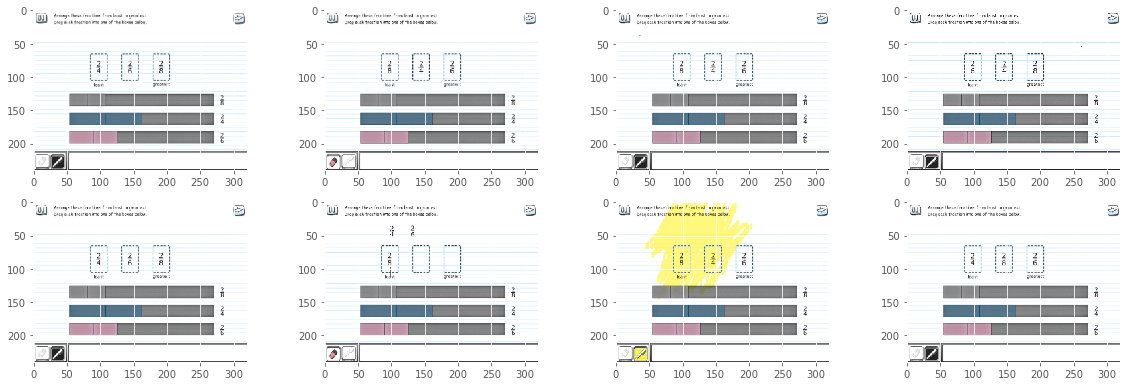

Cluster 1
                           _id behavioral_traits  bonus  correct      diff  \
1     5a00f18d9100de1a390072b8                []  False    False  0.093672   
1684  5a0108219100de1a395c7438                []  False    False  0.093672   
1710  5a0108879100de1a395e10a5                []  False    False  0.093672   
1734  5a0108dd9100de1a395f6264                []  False    False  0.093672   
1751  5a0109489100de1a3961080f                []  False    False  0.093672   
1754  5a01094a9100de1a39611241                []  False    False  0.093672   
1776  5a0109819100de1a3961e964                []  False    False  0.093672   
1789  5a01099b9100de1a39624f6a                []  False    False  0.093672   
1822  5a010a009100de1a3963e6e7                []  False    False  0.093672   
1823  5a010a019100de1a3963ea57                []  False    False  0.093672   

              id  incomplete            lesson  \
1     3y7UMHuR_i       False   review_lesson_1   
1684  3y7UMHuR_i       False  b

Cluster 5
                           _id behavioral_traits  bonus  correct      diff  \
57    5a00f2049100de1a3902514a                []  False    False  0.093672   
58    5a00f2049100de1a3902514b                []  False    False  0.093672   
254   5a00f4899100de1a390c7faf                []  False    False  0.093672   
864   5a00fc5c9100de1a392d324a                []  False    False  0.093672   
1000  5a00fdbc9100de1a3932c4bd                []  False    False  0.093672   
1001  5a00fdbc9100de1a3932c4be                []  False    False  0.093672   
498   5a00f6fc9100de1a39172f44                []  False    False  0.093672   

              id  incomplete            lesson  \
57    3y7UMHuR_i       False   review_lesson_1   
58    3y7UMHuR_i       False   review_lesson_1   
254   3y7UMHuR_i       False  basic_ordering_1   
864   3y7UMHuR_i       False  basic_ordering_1   
1000  3y7UMHuR_i       False  basic_ordering_1   
1001  3y7UMHuR_i       False  basic_ordering_1   
498   3y7UMHuR_

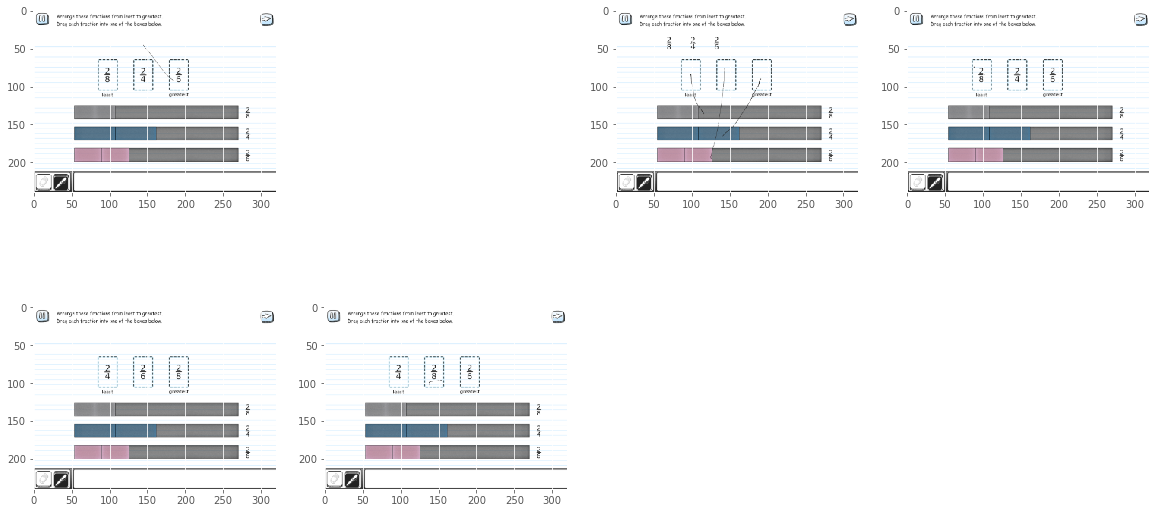

In [24]:
for row in range(len(top_ten_qual_id)):
    # print (top_ten_qual_id.iloc[row]['_id']['qual_id'], top_ten_qual_id.iloc[row]['count'])

    this_qid = top_ten_qual_id.iloc[row]['_id']['qual_id']
    count = top_ten_qual_id.iloc[row]['count']
    print ('Analysis {0} for qual_id {1} with {2} samples'.format(row, this_qid, count))


    prob_set = db.anon_student_task_responses.find({'qual_id':this_qid, 'correct': False})
    df3 = make_doc_data_set(prob_set)
    print ('Session 0 txt ', df3.iloc[0]['txt'])   
    df_top_ten.append(df3.copy())
    data_samples = df3['response_doc']
    km, km_transform = make_k_means(data_samples, clusters=10)
    df3['cluster'] = km.labels_
    print ('qual_id {0} has these clusters'.format(this_qid))
    print (df3['cluster'].value_counts())
      
    print ('Distances', km_transform.shape,  km_transform)
    df3['distance'] = df3['cluster']
    #for row in range(len(df3)):
    #    df3.iloc[row]['distance'] = km_transform[row][df3.iloc[row]['distance']]
        
    df3['distance'] =  df3.apply(lambda x: (km_transform[x.name][x['cluster']]) , axis=1)
    columns = 4
    num_images = 8
    # Look at top four clusters
    # Print 
    for cluster in (df3['cluster'].value_counts().keys())[:4]:
        plt.clf
        plt.figure(figsize=(20,10))
        print ('Cluster', cluster )

        cluster_data = df3[df3['cluster']==cluster]
        
        # Sort the cluster data 
        cluster_data.sort_values(by=['distance'], inplace=True)
        
        print (cluster_data[:10])
        images = []
        
        
        
        
        for idx in range(min(num_images, df3['cluster'].value_counts()[cluster])):
            #    images.append(Image(cluster_data.iloc[idx]['screenshot_url']))
            # create a file-like object from the url
            print (cluster_data.iloc[idx]['screenshot_url'])
            try:
                f = urllib.request.urlopen(cluster_data.iloc[idx]['screenshot_url'])
            except:
                print(' could not read {0}'.format(cluster_data.iloc[idx]['screenshot_url']))
                continue
            # read the image file in a numpy array
            a = plt.imread(f)
            #plt.imshow(a)
            #plt.show()
            #print(image)
            #display(image)
            plt.subplot(min(9, df3['cluster'].value_counts()[cluster]) / columns + 1, columns, idx + 1)
            plt.imshow(a)

        plt.show()
        

    
    

In [25]:
km_transform[1][1]

0.0

In [26]:
df3.index

RangeIndex(start=0, stop=2784, step=1)